<a href="https://colab.research.google.com/github/blaze010/CS6700-Reinforcement_Learning/blob/main/Assignment%201/Programming_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center >CS6700: Reinforcement Learning
## <center >Programming Assignment 1
## <center> TD Learning: SARSA and Q-Learning
###  Submitted by: 
### Gautham Govind A: EE19B022
### Vishnu Vinod: CS19B048 

## Importing necessary packages

In [1]:
from math import floor
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

## Utility functions

We require functions capable of converting from row-column based indexing and sequential indexing of grid cells. These are defined below: 

In [2]:
# Converts row_column format to sequential (state number) format
# Input  - 2D array of grid cells in (row, col) format
# Output - 1D array of corresponding state numbers
def row_col_to_seq(row_col, num_cols): 
    return row_col[:,0] * num_cols + row_col[:,1]

# Converts sequential (state number) format to row_column format 
# Input  - 1D array of grid cells in state number format
# Output - 2D array of grid cells in corresponding (row, col) format 
def seq_to_col_row(seq, num_cols): 
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [3]:
row_col_to_seq(np.array([[1,0]]), 2)

array([2])

## Defining the environment

The environment class, the definition of which has already been provided as part of the problem statement, is defined here:

In [4]:
class GridWorld:

    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters:
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
    
        # added to help naming conventions
        self.wind_mode = None
        self.start_mode = None
        self.stochasticity = None
        
        # 'windy' if wind=True | 'clear' if wind=False
        self.wind_mode = '_windy' if wind else '_clear'
        
        # 's1' if starting from [0,4] | 's2' if starting from [3,6] | None otherwise
        if (start_state == np.array([[0,4]])).all(): self.start_mode = '_s1'
        elif (start_state == np.array([[3,6]])).all(): self.start_mode = '_s2'
        

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias
        
        # 'detrm' if deterministic (p=1) | 'noisy' if stochastic (p!=1)
        self.stochasticity = '_detrm' if (p_good_transition == 1.) else '_noisy'

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
        return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):
            arr = self.P[next_state, :, 3]
            next_next = np.where(arr == np.amax(arr))
            next_next = next_next[0][0]
            return next_next, self.R[next_next]
        else:
            return next_state, self.R[next_state]

## Policy Definitions

First, we create an abstract BasePolicy() class:

In [5]:
class BasePolicy:
    @property
    def name(self):
        return 'base_policy'

    def select_action(self, state_id):
        raise NotImplemented

We first create an epsilon greedy policy which makes use of action value functions as the quantity based on which actions are chosen:

In [6]:
class EpsilonGreedy(BasePolicy):
    # epsilon      : epsilon value to be used by epsilon-greedy
    # actions      : Possible actions that can be taken up in each state
    #              : Default set for the current problem
    def __init__(self, epsilon, actions = np.array([0, 1, 2, 3])):
        self.eps = epsilon
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_eps'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):
        # To explore or not to explore, that is the question
        explore_or_exploit = np.random.binomial(1, 1 - self.eps)

        # if exploit, select the arm with maximum value of action value function else choose random arm
        if explore_or_exploit == 1:
            return self.actions[np.argmax(action_values[state_id, :])]
        else:
            return np.random.choice(self.actions)

Next, we create a SoftMax policy for exploration: 

In [7]:
class SoftMax(BasePolicy):

    # beta      : temperature to be used by softmax function
    def __init__(self, beta, actions = np.array([0, 1, 2, 3])):
        self.beta = beta
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_smx'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):

        # Finding the largest action value for this particular state
        max_action_val = max(action_values[state_id, :])

        # Computing the denominator of the softmax expression
        # Note that each term is divided by the largest exponential
        softmax_prob_denom = np.sum(np.exp((action_values[state_id, :] - max_action_val)/self.beta))

        # Computing the numerator term for each action
        # Again, terms are divided by the largest exponential to maintatin consistency with denominator
        softmax_prob = np.array([ np.exp((x - max_action_val) /self.beta)/softmax_prob_denom for x in list(action_values[state_id, :])])

        # sample according to the softmax distribution to get an arm
        return np.random.choice(self.actions, p = softmax_prob)

Finally, we also create a greedy deterministic policy which simply chooses the action with maximum Q-value. Although this is not explicitly asked for in the assignment, this can help us quantify how "good" the learned policy is which is necessary to perform hyperparameter tuning.

In [8]:
class Greedy(BasePolicy):
    # actions      : Possible actions that can be taken up in each state
    #              : Default set for the current problem
    def __init__(self,  actions = np.array([0, 1, 2, 3])):
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_greedy'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):

        #  select the arm with maximum value of action value function 
        return self.actions[np.argmax(action_values[state_id, :])]

## SARSA

In [9]:
class BaseUpdate:
    @property
    def name(self):
        return 'base_policy'
    
    def update(self, state_id):
        raise NotImplemented

We first define the SARSA update rule:

In [10]:
class SARSA(BaseUpdate):
    # alpha - learning rate
    # gamma - discount factor
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        
    # return name of policy
    @property
    def name(self):
        return 'sarsa'
    
    # q_current - Current estimate for a particular (state,action) pair
    # q_future - Future estimates for all actions on a particular state
    # reward - reward
    # next_action - specifies next action
    def update(self, q_current, q_future, reward, next_action = None):
        return q_current + self.alpha*(reward + self.gamma*q_future[next_action] - q_current)

## Q-Learning 

We now define the Q-Learning update rule

In [11]:
class QLearning(BaseUpdate):
    # alpha - learning rate
    # gamma - discount factor
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        
    # return name of policy
    @property
    def name(self):
        return 'qlrng'
    
    # q_current - Current estimate for a particular (state,action) pair
    # q_future - Future estimates for all actions on a particular state
    # reward - reward
    # next_action - specifies next action (redundant here)
    def update(self, q_current, q_future, reward, next_action = None):
        q_future_max = max(q_future)
        return q_current + self.alpha*(reward + self.gamma * q_future_max - q_current)

## Iterator for Experiments

The following iterator class forms the crux of the learning process. The class essentially has the ability to perform generalized policy iteration using some update policy and exploration policy. It also has several utility methods to help us visualize the results.

In [12]:
class TrainingIterator:
    def __init__(self, env, update_policy, exploration_policy, episodes):
        self.env = env                         # Grid World Env
        self.num_eps = episodes                # training episodes
        self.update_policy = update_policy     # SARSA vs Q-Learning
        self.explore = exploration_policy      # epsilon-greedy vs softmax
        
        self.steps = np.zeros(episodes)                                # total_steps for each episode
        self.rewards = np.zeros(episodes)                              # total_rewards for each episode
        self.q_vals = np.zeros((env.num_states, env.num_actions))      # Qvalues for each (state,action) pair
        self.hmap_visits = np.zeros(env.num_states)                    # heatmap of state visits (during training)
        self.hmap_qvals = np.zeros(env.num_states)                     # heatmap of Qvalues for optimal actions (after training)
        
    def train(self):
        
        # iterate over training episodes
        for episode in tqdm(range(self.num_eps), desc = 'Training Episodes'):
            
            current_state  = row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
            current_action = self.explore.select_action(current_state, self.q_vals)

            self.steps[episode] = 0
            self.rewards[episode] = 0
            self.hmap_visits[current_state] += 1

            while((current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols))) and (self.steps[episode] <= 100)):


                next_state, reward = self.env.step(current_state, current_action)
                next_action = self.explore.select_action(next_state, self.q_vals)
                self.q_vals[current_state, current_action] = self.update_policy.update(self.q_vals[current_state, current_action], self.q_vals[next_state], reward, next_action)
                
                if current_state != next_state:
                    self.hmap_visits[next_state] += 1
                    
                current_state = next_state
                current_action = next_action
                
                self.rewards[episode] += reward
                self.steps[episode] += 1
                
            if current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols)):
                self.steps[episode] = np.inf

                
        for state in range(self.env.num_states):
            self.hmap_qvals[state] = max(self.q_vals[state])
            
        return
    
    def plot_learnt_policy(self, verbose = False):
        
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_lnt_policy.jpg'

        greedy_policy = Greedy()

        hmap_greedy = np.zeros((self.env.num_rows, self.env.num_cols))
        reward_greedy = 0

        current_state  = row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
        current_action = greedy_policy.select_action(current_state, self.q_vals)

        hmap_greedy[self.env.start_state[0][0], self.env.start_state[0][1]] = 1

        steps = 0

        while((current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols))) and steps < 100):

            next_state, reward = self.env.step(current_state, current_action)
            next_action = greedy_policy.select_action(next_state, self.q_vals)    
            current_state = next_state
            current_action = next_action

            reward_greedy += reward
            hmap_greedy[seq_to_col_row(current_state, self.env.num_cols)[0][0], seq_to_col_row(current_state, self.env.num_cols)[0][1]] = 1
            steps += 1

        if verbose:
            plt.title("Learnt Policy")
            hmap = sns.heatmap(hmap_greedy, annot = False)
            plt.savefig('./plots/' + name, pad_inches = 0)
            plt.show()
        

        return reward_greedy[0]
    
    
    def plot_reward_curve(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_plt_rewards.jpg'
        
        sns.set_style("darkgrid")
        
        plt.title("Reward Curve")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.plot(np.arange(self.num_eps), self.rewards, 'b')
        
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_steps(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_plt_steps.jpg'
        
        sns.set_style("darkgrid")
        
        plt.title("Steps till Goal State")
        plt.xlabel("Episodes")
        plt.ylabel("Steps")
        plt.plot(np.arange(self.num_eps), self.steps, 'g')
        
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_hmap_visits(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_hmp_visits.jpg'
        
        n_rows, n_cols = self.env.num_rows, self.env.num_cols
        data = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                data[i,j] = self.hmap_visits[row_col_to_seq(np.array([[i,j]]), n_cols)[0]]
            
        plt.title("Heatmap of State Visits")
        hmap = sns.heatmap(data, annot = False)
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_hmap_qvals(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_hmp_qvals.jpg'
        
        n_rows, n_cols = self.env.num_rows, self.env.num_cols
        data = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                data[i,j] = self.hmap_qvals[row_col_to_seq(np.array([[i,j]]), n_cols)[0]]
            
        plt.title("Heatmap of Q-Values")
        hmap = sns.heatmap(data, annot = False)
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()

Next, we define a grid search function which returns the best hyperparameter set based on asymptotic optimality:

In [13]:
def asymptotic_grid_search(env, alphas, gammas, epsilons = None, betas = None, update_rule = 'sarsa' ):

  best_reward = -np.inf
  best_hyper_params_list = []

  

  if epsilons == None:
    for alpha in alphas:
      for gamma in gammas:
        for beta in betas:

          if update_rule == 'sarsa':
            update_policy = SARSA(alpha, gamma = gamma)
          else:
            update_policy = QLearning(alpha, gamma = gamma)

          print("Current configuration: alpha = {}, gamma = {}, beta = {}".format(alpha, gamma, beta))
          trainer = TrainingIterator(env, update_policy, SoftMax(beta = beta), 10000)
          trainer.train()
          reward = trainer.plot_learnt_policy()
          print("Total Reward:", reward)
          if reward > best_reward:
            best_reward = reward
            best_hyper_params = {}
            best_hyper_params['alpha'] = alpha
            best_hyper_params['gamma'] = alpha
            best_hyper_params['beta'] = alpha
            best_hyper_params_list.append(best_hyper_params)

  else:
    for alpha in alphas:
      for gamma in gammas:
        for epsilon in epsilons:

          if update_rule == 'sarsa':
            update_policy = SARSA(alpha, gamma = gamma)
          else:
            update_policy = QLearning(alpha, gamma = gamma)


          print("Current configuration: alpha = {}, gamma = {}, epsilon = {}".format(alpha, gamma, epsilon))
          trainer = TrainingIterator(env, update_policy, EpsilonGreedy(epsilon = epsilon), 10000)
          trainer.train()
          reward = trainer.plot_learnt_policy()
          print("Total Reward:", reward)

          if reward == best_reward:
            best_hyper_params = {}
            best_hyper_params['alpha'] = alpha
            best_hyper_params['gamma'] = gamma
            best_hyper_params['epsilon'] = epsilon
            best_hyper_params_list.append(best_hyper_params)

          if reward > best_reward:
            best_reward = reward
            best_hyper_params = {}
            best_hyper_params['alpha'] = alpha
            best_hyper_params['gamma'] = gamma
            best_hyper_params['epsilon'] = epsilon
            best_hyper_params_list = []
            best_hyper_params_list.append(best_hyper_params)

          

          
  print()
  print("Best Reward", best_reward)
  print("Asymptotic Best Hyper Parameters List", best_hyper_params_list)
  print()

  return best_reward, best_hyper_params_list
      





In [14]:
def regret_grid_search(env, best_reward, best_hyper_params, update_rule = 'sarsa', exploration_rule = 'epsilon'):

    best_regret = np.inf
    best_hyper = {}

    if exploration_rule == 'epsilon':

        for hyper_dict in best_hyper_params:
            
            if update_rule == 'sarsa':
                update_policy = SARSA(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'] )
            else:
                update_policy = QLearning(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'])

            print("Current configuration: alpha = {}, gamma = {}, epsilon = {}".format(hyper_dict['alpha'], hyper_dict['gamma'], hyper_dict['epsilon']))
            rewards = []
            for i in range(5):
                print("Running Experiment:", i+1)
                trainer = TrainingIterator(env, update_policy, EpsilonGreedy(epsilon = hyper_dict['epsilon']), 10000)
                trainer.train()
                rewards.append(trainer.rewards)
            rewards = np.mean(np.array(rewards), axis = 0)
            regret = np.sum((best_reward - rewards))

            print("Regret:", regret)

            if regret < best_regret:
                best_regret = regret
                best_hyper['alpha'] =  hyper_dict['alpha']
                best_hyper['gamma'] =  hyper_dict['gamma']
                best_hyper['epsilon'] =  hyper_dict['epsilon']

    else:

        for hyper_dict in best_hyper_params:
            
            if update_rule == 'sarsa':
                update_policy = SARSA(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'] )
            else:
                update_policy = QLearning(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'])

            print("Current configuration: alpha = {}, gamma = {}, beta = {}".format(hyper_dict['alpha'], hyper_dict['gamma'], hyper_dict['beta']))
            rewards = []
            for i in range(5):
                trainer = TrainingIterator(env, update_policy, SoftMax(beta = hyper_dict['beta']), 10000)
                trainer.train()
                rewards.append(trainer.rewards)
            rewards = np.mean(np.array(rewards), axis = 0)
            regret = np.sum((best_reward - rewards))

            print("Regret:", regret)

            if regret < best_regret:
                best_regret = regret
                best_hyper['alpha'] =  hyper_dict['alpha']
                best_hyper['gamma'] =  hyper_dict['gamma']
                best_hyper['beta'] =  hyper_dict['beta']

    print()
    print("Best Regret:", best_regret)
    print("Best Hyperparameters:", best_hyper)
    print()
    print()

    return best_regret, best_hyper


## SARSA - Grid Search

### 1) Start State: [0, 4], Clear, Deterministic, Epsilon-Greedy

In [13]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
goal_states = np.array([[0,9],[2,2],[8,7]])

start_state = np.array([[0,4]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=1.0, bias=0.5)

env = gw.create_gridworld()

In [ ]:
alphas = [0.001, 0.01, 0.1]
gammas = [0.5, 0.75, 1]
epsilons = [0.001, 0.01, 0.1]

best_reward, best_hyper = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = epsilons, betas = None )

### 2) Start State: [0, 4], Clear, Deterministic, SoftMax

In [19]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
goal_states = np.array([[0,9],[2,2],[8,7]])

start_state = np.array([[0,4]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=1.0, bias=0.5)

env = gw.create_gridworld()


alphas = [0.001, 0.01, 0.1]
gammas = [0.5, 0.75, 1]
betas = [0.1, 1, 10]

best_reward, best_hyper = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = None, betas = betas )

Current configuration: alpha = 0.001, gamma = 0.5, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:50<00:00, 198.50it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.5, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:51<00:00, 193.88it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.5, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:50<00:00, 197.58it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.75, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:47<00:00, 210.82it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.75, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:50<00:00, 196.61it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.75, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:49<00:00, 201.09it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 1, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:43<00:00, 227.91it/s]


Total Reward: -6.0
Current configuration: alpha = 0.001, gamma = 1, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:49<00:00, 202.47it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 1, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:50<00:00, 197.66it/s]


Total Reward: -100.0
Current configuration: alpha = 0.01, gamma = 0.5, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:46<00:00, 215.63it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 0.5, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:49<00:00, 202.21it/s]


Total Reward: -100.0
Current configuration: alpha = 0.01, gamma = 0.5, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:49<00:00, 201.29it/s]


Total Reward: -100.0
Current configuration: alpha = 0.01, gamma = 0.75, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:19<00:00, 500.66it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 0.75, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:44<00:00, 223.22it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 0.75, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:49<00:00, 202.52it/s]


Total Reward: -100.0
Current configuration: alpha = 0.01, gamma = 1, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:11<00:00, 905.82it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 1, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:14<00:00, 705.35it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 1, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:42<00:00, 237.93it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 0.5, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:45<00:00, 222.20it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 0.5, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:48<00:00, 207.59it/s]


Total Reward: -100.0
Current configuration: alpha = 0.1, gamma = 0.5, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:49<00:00, 202.72it/s]


Total Reward: -100.0
Current configuration: alpha = 0.1, gamma = 0.75, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:11<00:00, 840.55it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 0.75, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:41<00:00, 240.14it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 0.75, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:48<00:00, 204.97it/s]


Total Reward: -100.0
Current configuration: alpha = 0.1, gamma = 1, beta = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:06<00:00, 1510.52it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 1, beta = 1


Training Episodes:: 100%|██████████| 10000/10000 [00:08<00:00, 1213.03it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 1, beta = 10


Training Episodes:: 100%|██████████| 10000/10000 [00:29<00:00, 343.25it/s]

Total Reward: -6.0
Best Reward -6.0
Best Hyper Parameters {'alpha': 0.001, 'gamma': 0.001, 'beta': 0.001}


### 3) Start State: [0, 4], Windy, Deterministic, Epsilon-Greeedy

In [20]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
goal_states = np.array([[0,9],[2,2],[8,7]])

start_state = np.array([[0,4]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=1.0, bias=0.5)

env = gw.create_gridworld()


alphas = [0.001, 0.01, 0.1]
gammas = [0.5, 0.75, 1]
epsilons = [0.001, 0.01, 0.1]

best_reward, best_hyper = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = epsilons, betas = None )

Current configuration: alpha = 0.001, gamma = 0.5, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:19<00:00, 505.48it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.5, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:20<00:00, 491.78it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.5, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:21<00:00, 473.37it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.75, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:18<00:00, 530.65it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.75, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:19<00:00, 525.92it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 0.75, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:20<00:00, 498.86it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 1, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:17<00:00, 565.07it/s]


Total Reward: -7.0
Current configuration: alpha = 0.001, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:17<00:00, 580.52it/s]


Total Reward: -100.0
Current configuration: alpha = 0.001, gamma = 1, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:18<00:00, 530.46it/s]


Total Reward: -100.0
Current configuration: alpha = 0.01, gamma = 0.5, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:09<00:00, 1071.15it/s]


Total Reward: -7.0
Current configuration: alpha = 0.01, gamma = 0.5, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:09<00:00, 1102.61it/s]


Total Reward: -10.0
Current configuration: alpha = 0.01, gamma = 0.5, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:19<00:00, 517.92it/s]


Total Reward: -100.0
Current configuration: alpha = 0.01, gamma = 0.75, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:05<00:00, 1911.97it/s]


Total Reward: -12.0
Current configuration: alpha = 0.01, gamma = 0.75, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:05<00:00, 1893.65it/s]


Total Reward: -9.0
Current configuration: alpha = 0.01, gamma = 0.75, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:06<00:00, 1576.31it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 1, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:04<00:00, 2084.47it/s]


Total Reward: -9.0
Current configuration: alpha = 0.01, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:04<00:00, 2044.57it/s]


Total Reward: -6.0
Current configuration: alpha = 0.01, gamma = 1, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:05<00:00, 1674.79it/s]


Total Reward: -10.0
Current configuration: alpha = 0.1, gamma = 0.5, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:19<00:00, 507.40it/s]


Total Reward: -100.0
Current configuration: alpha = 0.1, gamma = 0.5, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:18<00:00, 552.11it/s]


Total Reward: -100.0
Current configuration: alpha = 0.1, gamma = 0.5, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:19<00:00, 505.42it/s]


Total Reward: -100.0
Current configuration: alpha = 0.1, gamma = 0.75, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:03<00:00, 3133.08it/s]


Total Reward: -8.0
Current configuration: alpha = 0.1, gamma = 0.75, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:03<00:00, 2899.45it/s]


Total Reward: -9.0
Current configuration: alpha = 0.1, gamma = 0.75, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:04<00:00, 2201.92it/s]


Total Reward: -7.0
Current configuration: alpha = 0.1, gamma = 1, epsilon = 0.001


Training Episodes:: 100%|██████████| 10000/10000 [00:03<00:00, 3055.26it/s]


Total Reward: -7.0
Current configuration: alpha = 0.1, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:03<00:00, 3066.63it/s]


Total Reward: -8.0
Current configuration: alpha = 0.1, gamma = 1, epsilon = 0.1


Training Episodes:: 100%|██████████| 10000/10000 [00:04<00:00, 2497.32it/s]

Total Reward: -10.0
Best Reward -6.0
Best Hyper Parameters {'alpha': 0.01, 'gamma': 0.75, 'epsilon': 0.1}


## Improved Experiment

Training Episodes: 100%|██████████| 10000/10000 [00:04<00:00, 2305.77it/s]


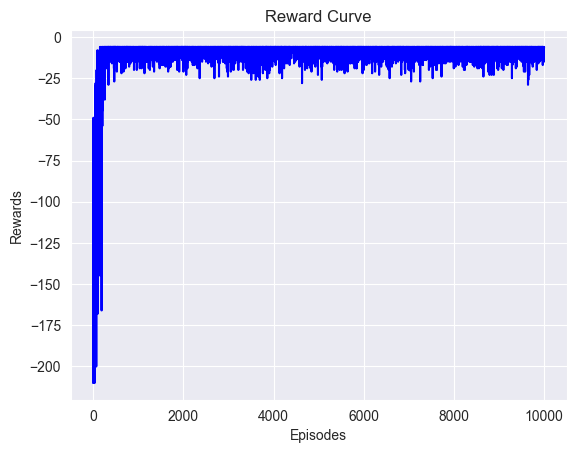

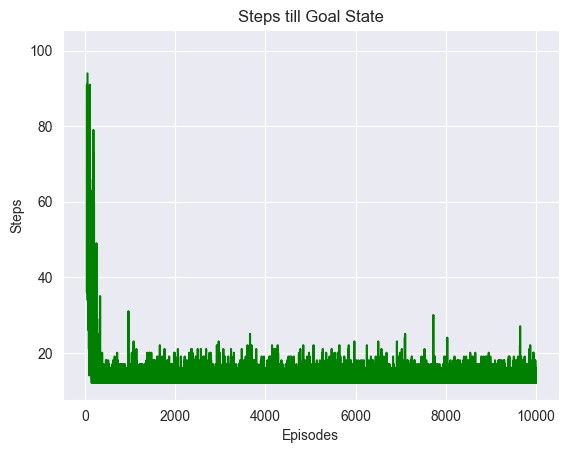

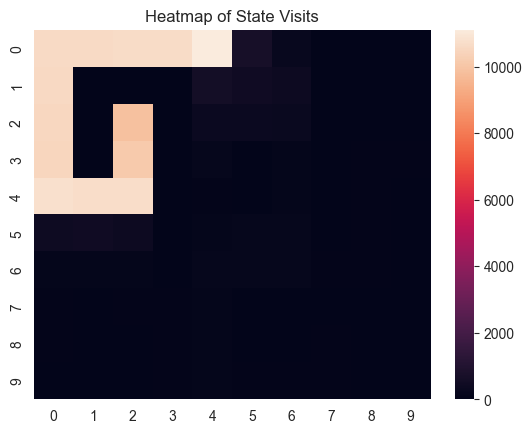

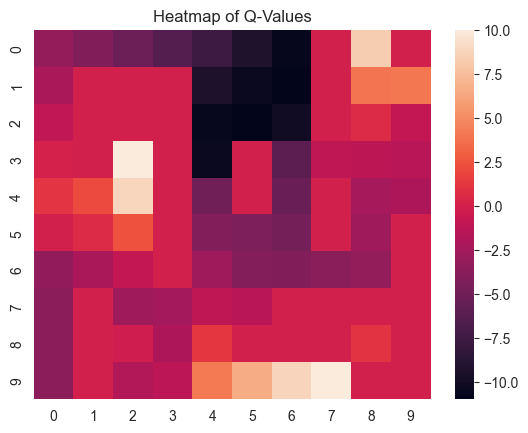

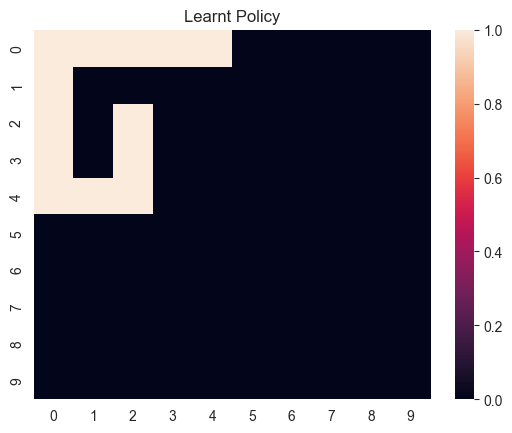

In [15]:
with open('./logs/sarsa_log.txt', 'w') as f:

    sys.stdout = f 

    wind_states = [False, True]
    transition_prob = [1.0, 0.7]
    start_states = [[0, 4], [3, 6]]
    epsilon_soft = ['epsilon', 'softmax']

    

    for start in start_states:
        for wind_state in wind_states:
            for prob in transition_prob:
                for exp in epsilon_soft:

                    print("Running Experiment with parameters: Start State: {}, Wind: {}, Transition Probability: {}, Exploration Policy: {}".format(start, wind_state, prob, exp))
                    print()
                    print()
                    num_cols = 10
                    num_rows = 10
                    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

                    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
                    restart_states = np.array([[3,7],[8,2]])
                    goal_states = np.array([[0,9],[2,2],[8,7]])

                    start_state = np.array([start])

                    # create model
                    gw = GridWorld(num_rows=num_rows,
                                    num_cols=num_cols,
                                    start_state=start_state,
                                    goal_states=goal_states, wind = wind_state)

                    gw.add_obstructions(obstructed_states=obstructions,
                                        bad_states=bad_states,
                                        restart_states=restart_states)

                    gw.add_rewards(step_reward=-1,
                                    goal_reward=10,
                                    bad_state_reward=-6,
                                    restart_state_reward=-100)

                    gw.add_transition_probability(p_good_transition=prob, bias=0.5)

                    env = gw.create_gridworld()

                    alphas = [0.001, 0.01, 0.1]
                    gammas = [0.5, 0.75, 1]

                    if exp == 'epsilon':
                        epsilons = [0.001, 0.01, 0.1]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = epsilons, betas = None )
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list,  update_rule = 'sarsa', exploration_rule = 'epsilon' )

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, SARSA(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), EpsilonGreedy(epsilon = best_hyper_params['alpha']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )


                    else:
                        betas = [0.001, 0.01, 0.1]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = None, betas = betas )
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list, update_rule = 'sarsa', exploration_rule = 'softmax')

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, SARSA(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), SoftMax(beta = best_hyper_params['beta']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )








## Experiment 1

In [48]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=1.0, bias=0.5)

env = gw.create_gridworld()

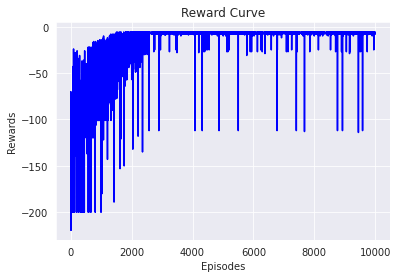

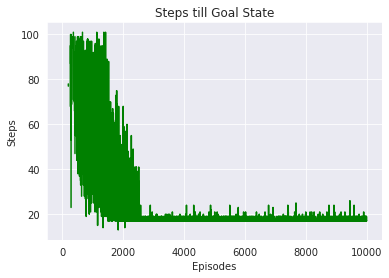

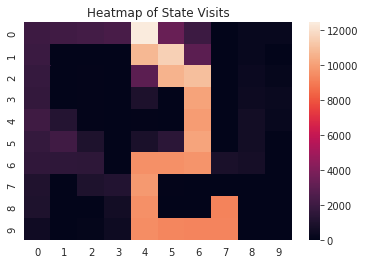

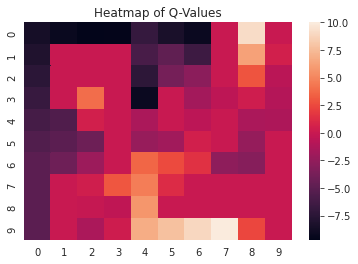

In [23]:
eps_greedy = EpsilonGreedy(epsilon = 0.01)
sarsa_update = SARSA(alpha = 0.01, gamma = 1)
trainer = TrainingIterator(env, sarsa_update, eps_greedy, 10000)
trainer.train()

trainer.plot_reward_curve()
trainer.plot_steps()
trainer.plot_hmap_visits()
trainer.plot_hmap_qvals()

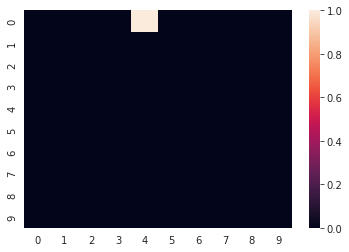

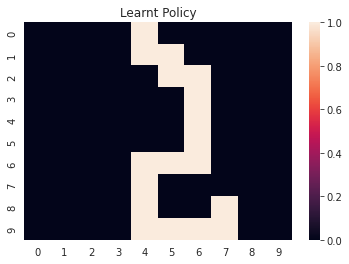

array([-6.])

In [24]:
trainer.plot_learnt_policy()

In [43]:
a, b = asymptotic_grid_search(env, alphas = [0.01, 0.05, 0.1, 0.3], gammas = [1], epsilons = [0.01], betas = None )

Current configuration: alpha = 0.01, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:12<00:00, 783.25it/s]


Total Reward: -6.0
Current configuration: alpha = 0.05, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:07<00:00, 1299.15it/s]


Total Reward: -6.0
Current configuration: alpha = 0.1, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:07<00:00, 1348.15it/s]


Total Reward: -6.0
Current configuration: alpha = 0.3, gamma = 1, epsilon = 0.01


Training Episodes:: 100%|██████████| 10000/10000 [00:07<00:00, 1394.28it/s]

Total Reward: -6.0


In [44]:
b

{'alpha': 0.01, 'gamma': 0.01, 'epsioln': 0.01}

Training Episodes:: 100%|██████████| 10000/10000 [00:16<00:00, 603.03it/s]


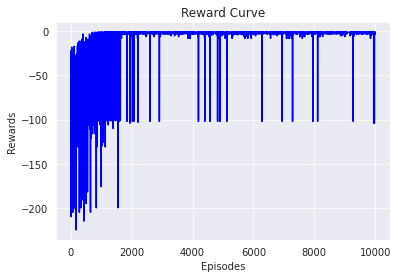

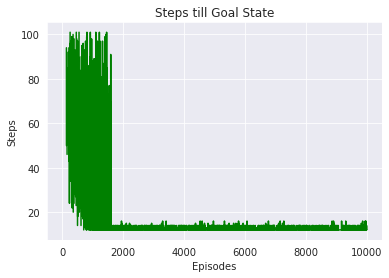

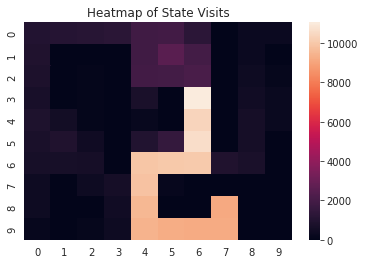

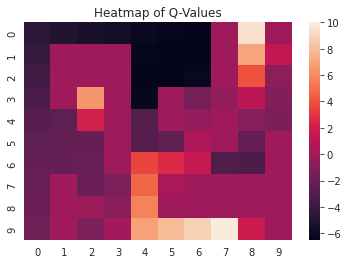

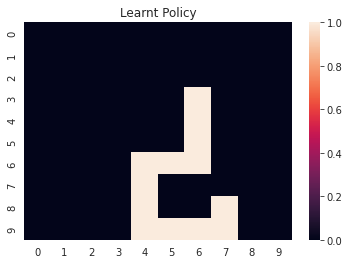

-1.0

In [49]:
eps_greedy = EpsilonGreedy(epsilon = 0.01)
sarsa_update = SARSA(alpha = 0.01, gamma = 1)
trainer = TrainingIterator(env, sarsa_update, eps_greedy, 10000)
trainer.train()

trainer.plot_reward_curve()
trainer.plot_steps()
trainer.plot_hmap_visits()
trainer.plot_hmap_qvals()
trainer.plot_learnt_policy(verbose = True)

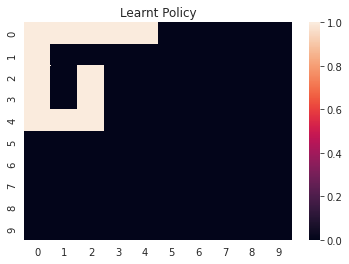

-6.0

In [47]:
trainer.plot_learnt_policy(verbose = True)